# 12-1. 프로젝트: 한영 번역기 만들기

## 라이브러리 버전을 확인해 봅니다
---
사용할 라이브러리 버전을 둘러봅시다.

In [2]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


## Step 1. 데이터 다운로드
---
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다
- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import random

print(tf.__version__)

2.6.0


In [10]:
file_path = os.getenv('HOME')+'/aiffel/korean-english-news-v1'
print(file_path)

/aiffel/aiffel/korean-english-news-v1


In [8]:
def load_file(file_name):
    with open(file_path+'/{}'.format(file_name), "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

In [19]:
raw_ko = load_file('korean-english-park.train.ko')
print('total data size:', len(raw_ko))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
total data size: 94123


In [20]:
raw_en = load_file('korean-english-park.train.en')
print('total data size:', len(raw_en))

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
total data size: 94123


## Step 2. 데이터 정제
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 `<start>` 토큰과 `<end>` 토큰을 추가하고 `split()` 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 `mecab` 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

### Step 2.1.

In [28]:
raw = zip(raw_ko, raw_en) # 하나로 합치기
raw_list = list(raw) # zip 객체를 list로 변환하여 데이터를 복사

In [29]:
set_raw = set(raw_list)
len(set_raw)

78968

In [30]:
cleaned_corpus_ko, cleaned_corpus_en = zip(*set_raw)

In [31]:
print('korean data size:', len(cleaned_corpus_ko))
print('english data size:', len(cleaned_corpus_en))

korean data size: 78968
english data size: 78968


In [32]:
cleaned_corpus_ko[100]

'최근에 조류독감으로 사망한 사람은 나이지리아 라고스에서 사망한 22 세의 여성이라고 WHO측은 4일 밝혔다.'

In [33]:
cleaned_corpus_en[100]

'The latest case confirmed by laboratory tests was that of a 22-year-old deceased female from Lagos, Nigeria, WHO officials said Saturday.'

## Step 2.2., 2.3.

In [46]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence) #한글에 적용할 수 있도록 변경

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [47]:
for ko, en in zip(cleaned_corpus_ko, cleaned_corpus_en):
    print(ko, en)
    break

그러나 공화당의 경우 1410만 명이 투표에 임했다. For Republicans, the number is 14.1 million.


In [48]:
enc_corpus = []
dec_corpus = []

cnt=0
for ko, en in zip(cleaned_corpus_ko, cleaned_corpus_en):
    temp_ko = preprocess_sentence(ko)
    temp_en = preprocess_sentence(en, s_token=True, e_token=True)

    if len(temp_ko) <= 40:
        enc_corpus.append(temp_ko)
        dec_corpus.append(temp_en)
    
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[500])   
print("English:", dec_corpus[500])  

korean data size: 16514
english data size: 16514
Korean: 영국태생의 아서 클라크는 년 스리랑카로 이민해
English: <start> the british born author who moved to sri lanka in has written more than sci fi books including <end>


In [50]:
print("Korean:", enc_corpus[100])   
print("English:", dec_corpus[100])  

Korean: 회 아카데미 상 후보작과 후보자들이 지난주 발표됐다 .
English: <start> nominations for the th academy awards were announced last week . <end>


데이터셋 평가
- 문장들의 짝은 잘 맞지만 문장 자체가 잘려서 나온다.

In [49]:
from konlpy.tag import Mecab

vocab_size = 50000
def tokenize(corpus, ko=False, en=True):
    if ko:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    if en:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

## 2. Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [44]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus, ko=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, en=True)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 40743
English Vocab Size: 17011


## Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [60]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [61]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                   return_sequences=True,
                                   dropout=0.3)  # Dropout 추가

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [62]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.3)  # Dropout 추가
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [63]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 17012)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


## Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.
```python
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
```

In [64]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [65]:
@tf.function #훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속한다
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src) #컨텍스트 벡터 생성
        h_dec = enc_out[:, -1] #t=0일 때, Decoder의 hidden satate는 Encoder의 Final State로 정의
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1) #<start> 토큰 문장 생성

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out) #다음 단어(t=1)를 예측
            
            #예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [66]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

import matplotlib.pyplot as plt
from tqdm import tqdm

train_losses = []
test_losses = []

EPOCHS = 25

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    train_losses.append(total_loss / len(idx_list))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))
    test_losses.append(test_loss / len(idx_list))

Test Epoch 25: 100%|██████████| 52/52 [00:02<00:00, 17.93it/s, Test Loss 1.3555]


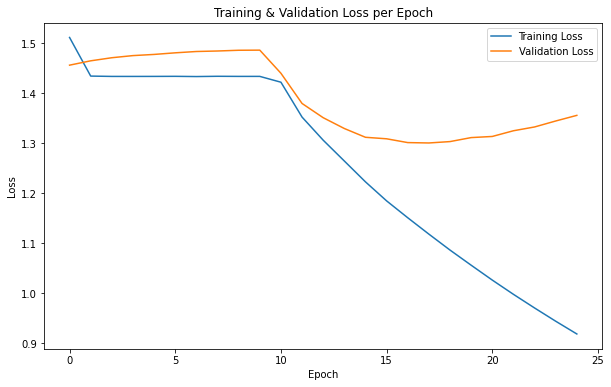

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

- epoch가 15에서 20 사이 구간에서 val loss가 다시 증가한다. 과적합이 일어나는 것 같다.

In [88]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

tf.keras.backend.clear_session()

# 모델 초기화
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# 옵티마이저 초기화
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

import matplotlib.pyplot as plt
from tqdm import tqdm

train_losses = []
test_losses = []

EPOCHS = 17

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    train_losses.append(total_loss / len(idx_list))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))
    test_losses.append(test_loss / len(idx_list))

  0%|          | 0/207 [00:00<?, ?it/s]


ValueError: in user code:

    /tmp/ipykernel_50/3176674513.py:7 train_step  *
        enc_out = encoder(src) #컨텍스트 벡터 생성
    /tmp/ipykernel_50/3555786268.py:12 call  *
        out = self.embedding(x)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1030 __call__  **
        self._maybe_build(inputs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:2659 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /opt/conda/lib/python3.9/site-packages/keras/utils/tf_utils.py:259 wrapper
        output_shape = fn(instance, input_shape)
    /opt/conda/lib/python3.9/site-packages/keras/layers/embeddings.py:149 build
        self.embeddings = self.add_weight(
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:647 add_weight
        variable = self._add_variable_with_custom_getter(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/training/tracking/base.py:813 _add_variable_with_custom_getter
        new_variable = getter(
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer_utils.py:117 make_variable
        return tf.compat.v1.Variable(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:266 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:212 _variable_v1_call
        return previous_getter(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:764 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


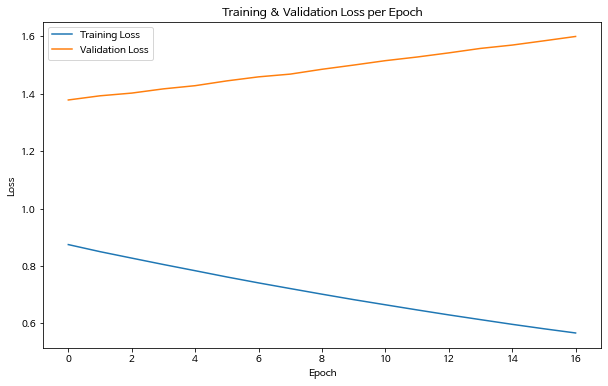

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
mecab = Mecab()

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = " ".join(mecab.morphs(sentence))  # Mecab 토큰화
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [83]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 오바마 는 대통령 이 다 .
Predicted translation: skimmed decline ramirez opposed cranley aug kellerman angelina terrific poignant wtvm anarchy specify resource shrank stipulated sundaravej osan precipitated staircase ueno implement automobile limit collaborating martinez queen gusting tribunal uncommon impede extraction kostunica underwent nevertheless fadel shinto generalist transported yess undervalues grayer centimetres arkin implement automobile limit collaborating martinez queen gusting tribunal uncommon impede extraction kostunica underwent nevertheless fadel shinto generalist transported yess undervalues grayer centimetres arkin 


/tmp/ipykernel_50/3615347810.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_50/3615347810.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


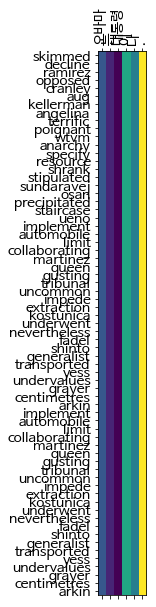

In [90]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: skimmed decline ramirez casino misunderstanding jefferson libyans hey joanne sang upside imam raquo unearthing rattray stern landsman hooded special conglomerates kyongsang nauseous flds opposed sumo uncommon monastery burress katanga international since stopping lets exacerbate sent countless ratings shutdown shirley preferring years band letters reclusive judges ingram made sachs oshima using kerviel meltdown depoe gamba striking pacific routes escaping nutrients implement exhibit indication statues illington motive outside spirit 


/tmp/ipykernel_50/3615347810.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_50/3615347810.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


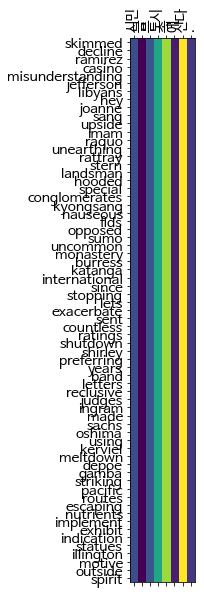

In [89]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: the world . <end> 


/tmp/ipykernel_50/272197317.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_50/272197317.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


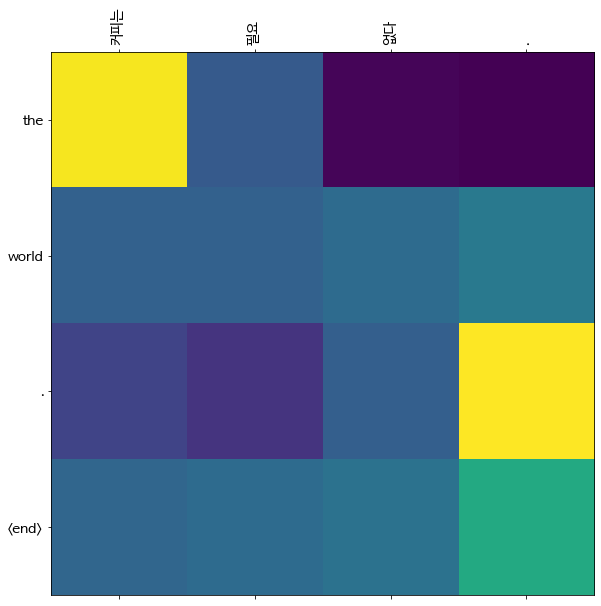

In [77]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the first round of baghdad . <end> 


/tmp/ipykernel_50/272197317.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_50/272197317.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


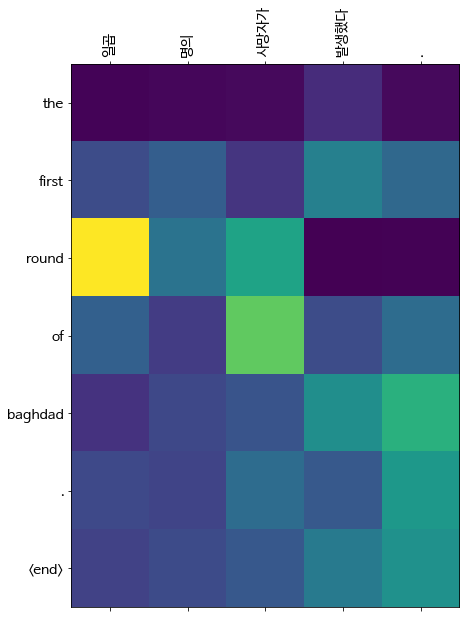

In [78]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

| 평가요소 | 상세기준 |
|----------|----------|
| 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다. | 	구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다. |
| 2. Attentional Seq2seq 모델이 정상적으로 구동된다. | seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다. |
| 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. | 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다. |


## 루브릭 평가
---
1. 출력 결과 전처리가 정상적으로 이루어진 것을 확인할 수 있었다.
2. training loss는 점차적으로 줄어드는 것을 볼 수 있었다.
3. 이상하게 출력이 된다. 


## 회고 
- set에 데이터를 저장하기 전에 list나 tuple로 변환하여 데이터를 복사해야지 빈 상태가 되지 않는다는 것을 배웠다.
- 과적합 때문인지는 잘 모르겠지만 학습이 제대로 되지 않았다. 애초에 데이터 셋 자체에 문제가 좀 있었는것 같다. transformer로 학습 시키는 것이 효과가 더 좋을것 같다.
- 단원 자체가 어려워서 제대로 이해했는지 모르겠다. 끝나고 다시 한번 보면서 되 짚어보아야겠다.